In [2]:
import pandas as pd
import json
import urllib.request
import requests
from datetime import datetime
from datetime import date
from bs4 import BeautifulSoup
import calendar
import re
from scipy.stats import pearsonr,spearmanr
#import searchtweets
#from searchtweets import ResultStream, gen_rule_payload, load_credentials

import nltk
nltk.download('popular')
nltk.download('nps_chat')
nltk.download('webtext')
nltk.download('udhr')
nltk.download('tagsets')
from nltk.book import *

import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
%matplotlib notebook


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


# Impact of Economic Indicator Releases and Sentiment in Predicting Securities Price Behavior

Question: Is the behavior of securities' prices subsequent to an economic indicator release influenced by factors such as tone of the release and discrepancies between the released values and subsequent revisions, as well as  market sentiment, in addition to the actual released numbers?  

It is a very well known fact that stocks go up when the unemployment report is down, but we want to find out if those other factors can give additional information about the magnitude of the moves and which securities may be most affected.

## Introduction  

In this preliminary exploration, we will be analyzing the impact of unemployment rate releases and tweet sentiment around the time of those releases, on constituents of the Standard and Poor 500 Index. We will be retrieving  the last ten years of historical data from several locations on the internet, extracting relevant information and analyzing it, in order to identify relevant features for building a machine learning model to predict which securities will be the most impacted on each release date.

## Data Sources

#### We will build our preliminary datasets for this project using data from the following internet locations:

* As unemployment rate is one of the most important economic indicators, this exploratory analysis uses this indicator, but additional indicators will be added as features to the model as they are proven relevant. We retrieved historical data on unemployment rates from the [U.S. Bureau of Labor Statistics](https://data.bls.gov/timeseries/LNU04000000). This data reflects normal revisions in the months following the original announcements and is not seasonally adjusted.  

* Because the historical unemployment data above has been revised after the original announcement, and we are considering the impact of the announcements, we retrieved the original text of the documents released on the first Friday of each month for the last ten years. The links to locations of these documents are found on the [Employment Situation Archived News Releases page](https://www.bls.gov/bls/news-release/empsit.htm).  

* We are using the components of the S&P500 Index as our securities sample for this exploratory analysis. Other securities such as bonds and future contracts can be added later for a more complete picture. Because Standard and Poor doesn't publish an official list of the index constituents, we will be using a dataset from [DataHub](https://datahub.io/core/s-and-p-500-companies/r/constituents.csv) as a relevant and accurate enough unofficial list for sampling purposes.  

* We will be retrieving daily price and volume data for the list of ~500 stocks from [Tiingo](https://www.tiingo.com) using their RESTful API.  

* Finally, we will be extracting historical data from [Twitter](https://twitter.com/home?lang=en) using their full archive API to extract market sentiment data on release dates. To determine tweet sentiment, we will be using a list of sentiment words from [Minqing Hu and Bing Liu's Sentiment Analysis: mining opinions, sentiments, and emotions](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), who have done extensive research to shape the natural language toolkit (NLTK).

### Retrieving historical unemployment rates from [U.S. Bureau of Labor Statistics](https://data.bls.gov/timeseries/LNU04000000)  
* These files have been downloaded and converted to csv format for ease of use, and reside in this repository

In [65]:
df_URV=pd.read_csv('LNU04000000_OrigValue.csv', skiprows=12)
df_URC=pd.read_csv('LNU04000000_1MPctChg.csv', skiprows=12)
df_UR_Releases=df_URV.loc[:,['Year','Period','Value']]
df_UR_Releases['Percent Change']=df_URC['Value']
df_UR_Releases.rename(columns={'Value':'Revised Value'},inplace=True)
df_UR_Releases.head()

,Year,Period,Revised Value,Percent Change
0,2010,M01,10.6,9.3
1,2010,M02,10.4,-1.9
2,2010,M03,10.2,-1.9
3,2010,M04,9.5,-6.9
4,2010,M05,9.3,-2.1


### Retrieving relevant text from original unemployment news releases
[Employment Situation Archived News Releases page](https://www.bls.gov/bls/news-release/empsit.htm)  
Warning!: Running time: 2-3 minutes

In [66]:
release_dates=[]
announcements=[]
linkpage=BeautifulSoup(urllib.request.urlopen('https://www.bls.gov/bls/news-release/empsit.htm').read(), 'html.parser')
pattern=re.compile(r'/news.release/archives/empsit_\d+.htm')
for year in range(2010,2021):
    for month in list(calendar.month_name[1:14]):
        if year==2020 and month=='July':
            break
        try:
            search_str=str(month)+' '+str(year)+' '+'Employment Situation'
            line=linkpage.find(text=search_str).parent
            url='https://www.bls.gov'+pattern.search(str(line)).group(0)
            file=str(urllib.request.urlopen(url).read(38000))
            release_dates.append(re.search(r'\d+',url).group(0))
            announcement=re.search(r'rate[,\s]?[\w\s\d\.]+ percent',file).group(0)
            if 'percent.' in announcement or 'Asian' in announcement or 'black' in announcement:
                raise
            announcements.append(announcement)
        except Exception:
            #This method takes longer but is more reliable, so we will save it for when the previous method fails
            file=BeautifulSoup(urllib.request.urlopen(url).read(), 'html.parser').pre.get_text()[400:600].replace('\n','').replace('\r','')
            announcements.append(re.search(r'rate[,\s]?[\w\s\d\.]+ percent',file).group(0))
df_UR_Releases['Release Date']=pd.to_datetime([x[:2]+'/'+x[2:4]+'/'+x[4:] for x in release_dates])
df_UR_Releases['Announcement']=announcements

In [67]:
df_UR_Releases['Announcement'].head()

0    rate fell from 10.0 to 9.7 percent
1              rate held at 9.7 percent
2              rate held at 9.7 percent
3          rate edged up to 9.9 percent
4        rate edged down to 9.7 percent
Name: Announcement, dtype: object

### Processing text to determine tone of announcement

In [68]:
sentiment_words=[]
for item in df_UR_Releases['Announcement']:
    sentiment_words.append(re.search('[A-Za-z\s]+',item.replace('rate','').replace('percent','')).group(0))
set(sentiment_words)

{' at ',
 ' declined by ',
 ' declined from ',
 ' declined to ',
 ' decreased to ',
 ' edged down by ',
 ' edged down to ',
 ' edged up from ',
 ' edged up to ',
 ' fell by ',
 ' fell from ',
 ' held at ',
 ' remained at ',
 ' rose by ',
 ' rose to ',
 ' was ',
 ' was about unchanged at ',
 ' was essentially unchanged at ',
 ' was little changed at ',
 ' was unchanged at ',
 ' waslittle changed at ',
 'was essentially unchanged at ',
 'was little changed at '}

In [74]:
def release_tone(txt):
    """Assigns a -1 when comments are positive"""
    """Remember: Unemployment rates going DOWN IS GOOD"""
    positive=['edged up','rose']
    negative=['declined','decreased','edged down','fell']
    for word in positive:
        if word in txt:
            return -1
    for word in negative:
        if word in txt:
            return 1
    return 0
df_UR_Releases['Tone']=0
for index in df_UR_Releases.index:
    df_UR_Releases['Tone'][index]=release_tone(df_UR_Releases['Announcement'][index])
df_UR_Releases['Announced Value']=df_UR_Releases['Announcement'].str.extract(r'(\d+\.\d)( percent$)').loc[:,0].apply(float)
df_UR_Releases['Announced Percent Change']=-3
for index in df_UR_Releases.index[1:]:
    df_UR_Releases['Announced Percent Change'][index]=(df_UR_Releases[
        'Announced Value'][index]-df_UR_Releases['Announced Value'][index-1])/(df_UR_Releases['Announced Value'][index-1])*100
df_UR_Releases['Discrepancy']=df_UR_Releases['Announced Value']-df_UR_Releases['Revised Value']
df_UR_Releases['Tone']

C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0      1
1      0
2      0
3     -1
4      1
      ..
121    0
122   -1
123   -1
124    1
125    1
Name: Tone, Length: 126, dtype: int64

### Visualizing discrepancies between announced and revised rates

In [198]:
df_UR_Releases.head()

,Year,Period,Revised Value,Percent Change,Release Date,Announcement,Tone,Announced Value,Announced Percent Change,Discrepancy
0,2010,M01,10.6,9.3,2010-02-05,rate fell from 10.0 to 9.7 percent,1,9.7,-3,-0.9
1,2010,M02,10.4,-1.9,2010-03-05,rate held at 9.7 percent,0,9.7,0,-0.7
2,2010,M03,10.2,-1.9,2010-04-02,rate held at 9.7 percent,0,9.7,0,-0.5
3,2010,M04,9.5,-6.9,2010-05-07,rate edged up to 9.9 percent,-1,9.9,2,0.4
4,2010,M05,9.3,-2.1,2010-06-04,rate edged down to 9.7 percent,1,9.7,-2,0.4


## Visualizing correlations

<IPython.core.display.Javascript object>


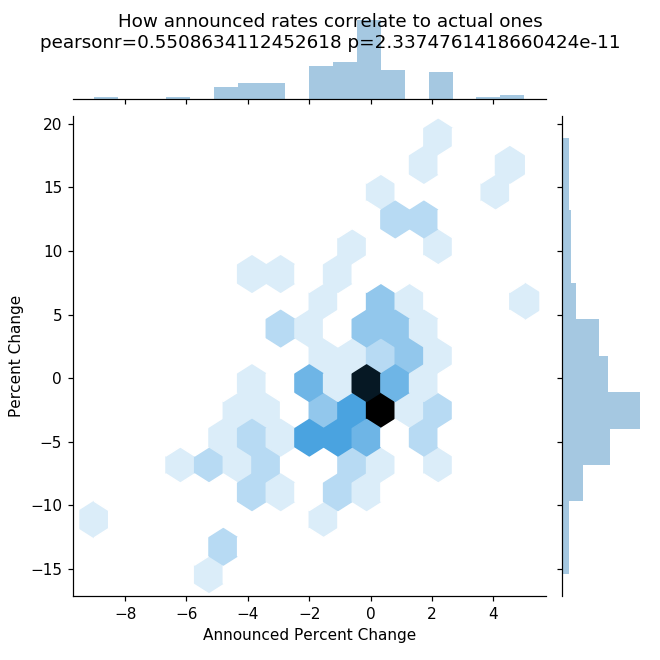

Text(0.5, 0.98, 'How announced rates correlate to actual ones\npearsonr=0.5508634112452618 p=2.3374761418660424e-11')

In [94]:
#Make a copy to remove outliers
df_copy=df_UR_Releases.copy(deep=True)
df_copy.at[123,'Percent Change']=0
df_copy.at[123,'Announced Percent Change']=0
df_copy.at[122,'Percent Change']=0
df_copy.at[122,'Announced Percent Change']=0
df_copy.at[125,'Percent Change']=0
df_copy.at[125,'Announced Percent Change']=0
plot1=sns.jointplot(x='Announced Percent Change',y='Percent Change',data=df_copy,kind='hex')
stat=pearsonr(df_copy['Announced Percent Change'],df_copy['Percent Change'])
title="How announced rates correlate to actual ones\npearsonr={} p={}".format(stat[0],stat[1])
plot1.fig.suptitle(title)

<IPython.core.display.Javascript object>


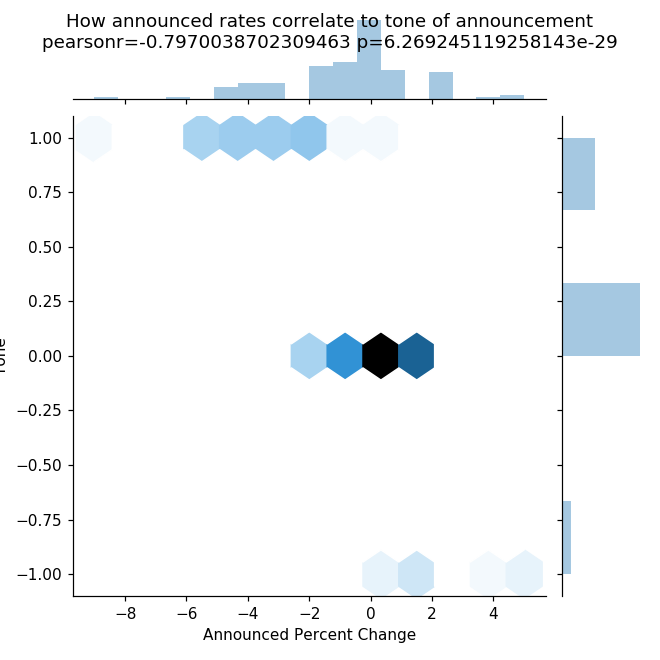

Text(0.5, 0.98, 'How announced rates correlate to tone of announcement\npearsonr=-0.7970038702309463 p=6.269245119258143e-29')

In [96]:
stat=pearsonr(df_copy['Announced Percent Change'],df_copy['Tone'])
title="How announced rates correlate to tone of announcement\npearsonr={} p={}".format(stat[0],stat[1])
sns.jointplot(x='Announced Percent Change',y='Tone',data=df_copy,kind='hex').fig.suptitle(title)

<IPython.core.display.Javascript object>


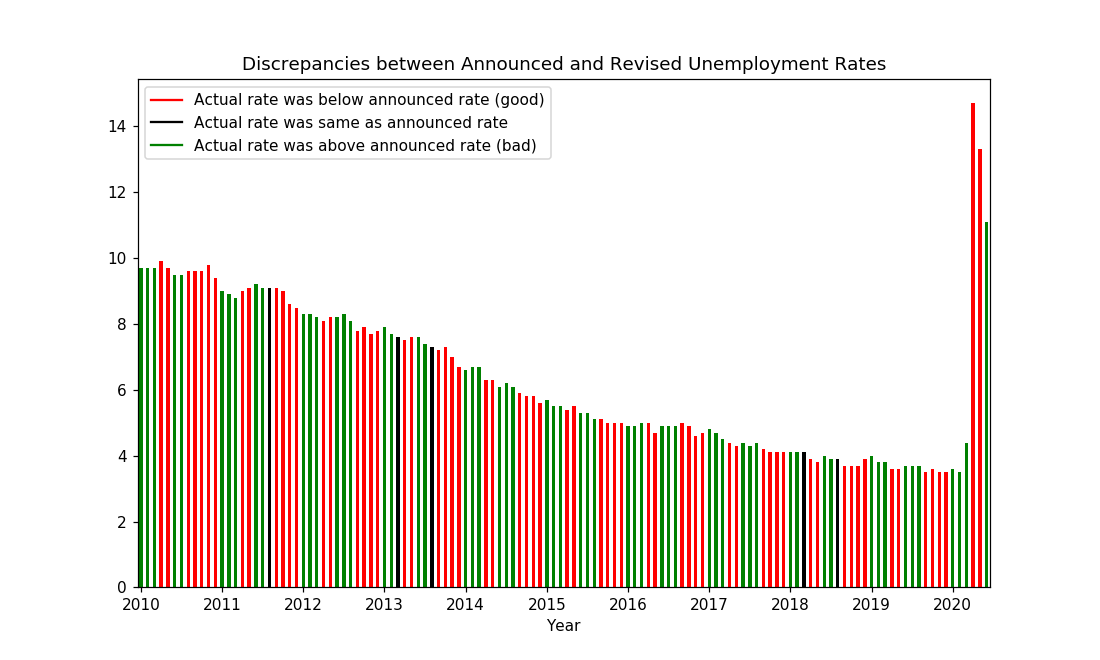

In [25]:
fig=plt.figure(figsize=(10,6))
ax=plt.gca(title='Discrepancies between Announced and Revised Unemployment Rates')
colors=['red' if x>0 else 'black' if x==0 else 'green' for x in df_UR_Releases['Discrepancy']]
df_UR_Releases.plot(kind='bar', x='Year', y='Announced Value', color=colors, label=None, ax=ax)
df_UR_Releases.plot(kind='line', x='Year', y='Announced Value', color='red', label=None, ax=ax)
df_UR_Releases.plot(kind='line', x='Year', y='Announced Value', color='black', label=None, ax=ax)
df_UR_Releases.plot(kind='line', x='Year', y='Announced Value', color='green', label=None, ax=ax)
ax.set_xticks(ax.get_xticks()[::12])
ax.set_xticklabels([str(x) for x in range(2010,2021)])
plt.xticks(rotation=0)
handles, labels = ax.get_legend_handles_labels()
labels[0]='Actual rate was below announced rate (good)'
labels[1]='Actual rate was same as announced rate'
labels[2]='Actual rate was above announced rate (bad)'
labels=labels[:3]
ax.legend(handles, labels)

### Retrieving historical stock prices

#### Retrieving S&P 500 tickers from [DataHub](https://datahub.io/core/s-and-p-500-companies/r/constituents.csv)

In [26]:
df_SP500=pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv')
tickers=list(df_SP500['Symbol'])
tickers[0]='SPY'
tickers[:20]

['SPY',
 'AOS',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AAP',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN']

#### Using [Tiingo](https://www.tiingo.com) RESTful API to retrieve 10 year daily historical data for stocks in sample  
Warning: Running time can reach 10 minutes.

In [27]:
def get_EOD_data(symbol,sdate,edate):
    
    base_url='https://api.tiingo.com/tiingo/daily/'+symbol+'/prices?'
    api_key='9fa4df1e30e2fb224f1a625b7c43867b1880d05f'
    parameters={
        'token':api_key,
        'startDate':sdate,
        'endDate': edate,
    }
    response = requests.get(base_url, params=parameters)
    return response
d_all_EOD={}
errors=[]
for n,ticker in enumerate(tickers):
    try:
        df_EOD=pd.DataFrame(get_EOD_data(ticker,'2010-1-1','2020-7-20').json())
        if len(df_EOD)<360:
            raise
        df_EOD['date']=df_EOD['date'].apply(lambda x:x[:10]).apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
        d_all_EOD[ticker]=df_EOD
    except Exception as err:
        errors.append((ticker,err))

In [12]:
d_all_EOD['SPY'].head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2010-01-04,113.33,113.39,111.51,112.37,118857369,91.796474,91.845073,90.322287,91.018881,118857369,0.0,1.0
1,2010-01-05,113.63,113.68,112.85,113.26,111519230,92.039472,92.079971,91.407677,91.739774,111519230,0.0,1.0
2,2010-01-06,113.71,113.99,113.43,113.52,116017127,92.104271,92.331069,91.877473,91.950373,116017127,0.0,1.0
3,2010-01-07,114.19,114.33,113.18,113.50,130502017,92.493068,92.606467,91.674975,91.934173,130502017,0.0,1.0
4,2010-01-08,114.57,114.62,113.66,113.89,126357911,92.800865,92.841364,92.063771,92.250070,126357911,0.0,1.0


### Documenting changes in price in response to announcements
Warning: Running time 1-2 minutes

In [29]:
df_changes=pd.DataFrame(index=d_all_EOD.keys(),columns=df_UR_Releases['Release Date'])
for ticker in d_all_EOD.keys():
    #for date in df_UR_Releases['Release Date']:
    for date in df_changes:
        try:
            row=d_all_EOD[ticker][d_all_EOD[ticker]['date']==date]
            index=int(row.index[0])      
        except Exception:
            #Keep trying dates for tickers that start at a later date than our chosen January 2010
            if d_all_EOD[ticker]['date'].iloc[0]>date:
                continue
            #Sometimes the market is closed on the Friday when Unemployment Rates are announced, so we skip to Monday
            try:
                row=d_all_EOD[ticker][d_all_EOD[ticker]['date']==date+timedelta(days=3)]
                index=int(row.index[0])
            except Exception as err:
                errors.append((ticker,err,date))
                continue
        close=row.iloc[0]['adjClose'] 
        if index>0:
            prev_close=d_all_EOD[ticker].iloc[index-1]['adjClose']
            change=((close-prev_close)/prev_close)*100
            df_changes.loc[ticker,date]=change

In [102]:
df_changes.head(20)

Release Date,2010-02-05,2010-03-05,2010-04-02,2010-05-07,2010-06-04,2010-07-02,2010-08-06,2010-09-03,2010-10-08,2010-11-05,...,2019-10-04,2019-11-01,2019-12-06,2020-01-10,2020-02-07,2020-03-06,2020-04-03,2020-05-08,2020-06-05,2020-07-02
SPY,0.206689,1.42933,0.814941,-1.48926,-3.51368,-0.544959,-0.407621,1.29716,0.560877,0.376247,...,1.35321,0.926384,0.913403,-0.28777,-0.532966,-1.65311,-1.44542,1.65462,2.56295,0.550689
AOS,0.554752,0.780426,2.32292,-3.78879,-3.06489,0.560515,-0.621005,2.03466,0.694444,-0.0501588,...,1.13333,1.20773,-0.234542,1.21148,-3.0254,2.54624,-0.194769,3.41722,2.82776,2.20302
ABT,0.278707,0.443787,-0.0566465,-0.571429,-2.51414,0,1.18047,0.256866,0.437429,0.0786164,...,1.13482,-1.13623,0.281558,-1.24942,-1.78831,1.51515,0.0125881,-0.308543,1.82436,0.643824
ABBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.09682,2.76556,0.299815,-1.2748,5.86144,-1.9755,-2.34261,-0.308715,0.870593,-0.262255
ABMD,1.9347,1.50659,1.5,-3.58343,-4.78564,-1.12474,-2.72904,1.25786,-0.552486,-0.0841751,...,1.3291,4.43684,0.0793357,2.97386,-4.64262,1.66332,-1.31212,-0.669038,5.84273,3.37748
ACN,-0.172371,0.659985,0.286807,-1.87394,-2.43065,-0.888192,0.750563,1.55304,-0.13089,0,...,2.06125,1.51009,1.35101,0.732476,-1.20471,-2.08699,-2.63646,0.774945,2.65387,0.526586
ATVI,0.492126,0,0.922819,0.667302,-2.72727,1.33333,-6.46809,1.81653,0.816697,-2.83749,...,2.53375,-0.374799,0.400073,-0.65723,2.10753,-2.51951,-1.31622,0.0547196,-0.544335,-0.66641
ADBE,1.64392,0.629651,0.699496,-0.215451,-3.97416,0.262566,-0.713315,0.237933,-5.92541,-1.08622,...,1.67401,-0.0395783,1.056,-0.187986,-0.37283,-4.06233,-3.40505,0.199029,1.84033,0.713945
AAP,-0.513071,1.22068,0.731822,-0.995475,-2.58303,-1.33462,-2.07908,0.444129,-0.408233,-0.273515,...,0.0500438,1.44018,1.52998,-2.52502,-1.07167,0.780019,-4.25291,4.3809,2.74262,-0.0774921
AMD,2.22531,1.29412,1.70758,1.33011,-6.73188,-2.977,-0.666667,2.69815,2.62009,0.5,...,1.15063,2.82935,0.0252398,-1.64386,0.831306,0.997714,-4.27062,2.38691,0.893027,-0.456447


## Analizing correlations for each stock

In [97]:
df_corr=pd.DataFrame(index=df_changes.index,columns=[
    'Announced Percent Change','Actual Percent Change','Tone'])
for ticker in df_corr.index:
    df_corr.at[ticker,'Announced Percent Change'] = pearsonr(
        df_changes.fillna(0).loc[ticker],df_UR_Releases['Announced Percent Change'])[0]
    df_corr.at[ticker,'Actual Percent Change'] = pearsonr(
        df_changes.fillna(0).loc[ticker],df_UR_Releases['Percent Change'])[0]
#    df_corr.at[ticker,'Tone'] = pearsonr(
#        df_changes.fillna(0).loc[ticker].apply(dir_func),df_UR_Releases['Tone'])[0]
    df_corr.at[ticker,'Tone'] = pearsonr(
        df_changes.fillna(0).loc[ticker],df_UR_Releases['Tone'])[0]

df_corr.sort_values('Announced Percent Change')


,Announced Percent Change,Actual Percent Change,Tone
MSI,-0.203821,-0.156077,0.0710594
FISV,-0.18423,-0.183963,0.0777312
DLR,-0.175342,-0.189013,0.0434858
FLT,-0.157655,-0.160265,0.0122825
BLL,-0.152639,-0.149896,0.0879726
...,...,...,...
BKR,0.48607,0.469535,-0.194592
LEG,0.504489,0.474163,-0.0539815
NWSA,0.573994,0.541619,-0.215798
NWS,0.616031,0.5837,-0.228158


In [98]:
df_corr.sort_values('Actual Percent Change')

,Announced Percent Change,Actual Percent Change,Tone
DLR,-0.175342,-0.189013,0.0434858
FISV,-0.18423,-0.183963,0.0777312
FLS,-0.138898,-0.161614,0.0949846
FLT,-0.157655,-0.160265,0.0122825
MSI,-0.203821,-0.156077,0.0710594
...,...,...,...
BKR,0.48607,0.469535,-0.194592
LEG,0.504489,0.474163,-0.0539815
NWSA,0.573994,0.541619,-0.215798
NWS,0.616031,0.5837,-0.228158


In [100]:
df_corr.sort_values('Tone',ascending=False)

,Announced Percent Change,Actual Percent Change,Tone
SYY,0.0775208,0.0834331,0.165384
AWK,-0.109415,-0.105936,0.160527
DXCM,-0.00921864,3.89116e-05,0.13951
O,0.00569443,-0.0146656,0.138545
GPN,-0.0266128,-0.00794697,0.137203
...,...,...,...
CHTR,0.0169498,0.0445928,-0.196951
LB,0.393358,0.351399,-0.204371
NWSA,0.573994,0.541619,-0.215798
CTL,0.301827,0.283615,-0.216319


## Finding instances when stocks move in a direction consistent with announcement

In [162]:
def dir_func(number):
    if number==0:
        return 0
    return number/abs(number)
df_cons=df_changes.fillna(0).copy(deep=True)
rate_announcements=df_UR_Releases.loc[:,['Release Date','Announced Percent Change']]
rate_announcements['Announced Percent Change']=rate_announcements['Announced Percent Change'].apply(dir_func)
rate_announcements.set_index('Release Date',inplace=True)
for date in df_cons:
    df_cons[date]=df_cons[date].apply(dir_func)
    for ticker in df_cons.index:
        stock_dir=df_cons.loc[ticker,date]
        rate_dir=rate_announcements.loc[date,'Announced Percent Change']
        #print(stock_dir,rate_dir)
        if (stock_dir==-rate_dir):
            df_cons.at[ticker,date]=1
        else:
            df_cons.at[ticker,date]=0
(df_cons.sum(axis=1).sort_values(ascending=False)/len(rate_announcements)*100)

CCI     46.825397
AIV     46.031746
MCD     46.031746
WEC     45.238095
DRE     45.238095
          ...    
SYF     26.190476
KEYS    25.396825
KHC     24.603175
BKR     23.015873
CFG     22.222222
Length: 490, dtype: float64

In [185]:
df_cons.loc['FCX',datetime(2016,7,8):]

Release Date
2016-07-08    0.0
2016-08-05    0.0
2016-09-02    0.0
2016-10-07    1.0
2016-11-04    1.0
2016-12-02    1.0
2017-01-06    0.0
2017-02-03    1.0
2017-03-10    0.0
2017-04-07    0.0
2017-05-05    1.0
2017-06-02    0.0
2017-07-07    0.0
2017-08-04    1.0
2017-09-01    0.0
2017-10-06    0.0
2017-11-03    0.0
2017-12-08    0.0
2018-01-05    0.0
2018-02-02    0.0
2018-03-09    0.0
2018-04-06    0.0
2018-05-04    1.0
2018-06-01    1.0
2018-07-06    0.0
2018-08-03    1.0
2018-09-07    0.0
2018-10-05    0.0
2018-11-02    0.0
2018-12-07    0.0
2019-01-04    0.0
2019-02-01    1.0
2019-03-08    0.0
2019-04-05    0.0
2019-05-03    1.0
2019-06-07    0.0
2019-07-05    1.0
2019-08-02    0.0
2019-09-06    0.0
2019-10-04    0.0
2019-11-01    0.0
2019-12-06    1.0
2020-01-10    0.0
2020-02-07    1.0
2020-03-06    0.0
2020-04-03    1.0
2020-05-08    0.0
2020-06-05    1.0
2020-07-02    1.0
Name: FCX, dtype: float64

#### Analyzing biggest gainers

In [163]:
maxval_ticker=df_changes.max(axis=1).idxmax()
maxval_date=df_changes.max(axis=0).idxmax()
maxval=df_changes.max().max()
maxval_ticker,maxval_date,maxval

('OXY', Timestamp('2020-06-05 00:00:00'), 33.69774919624328)

In [164]:
df_changes.loc[maxval_ticker].sort_values(ascending=False)

Release Date
2020-06-05    33.6977
2020-05-08    8.21326
2019-11-01    4.41975
2015-10-02    4.27467
2012-02-03    4.21405
               ...   
2010-03-05   -3.38462
2019-03-08   -3.42257
2019-08-02   -3.74271
2010-06-04   -5.42692
2020-03-06    -14.676
Name: OXY, Length: 126, dtype: object

In [165]:
df_changes[maxval_date].sort_values(ascending=False).head(20)

OXY     33.6977
APA     23.6154
RCL     20.3675
MRO      17.496
CCL     16.3961
SPG     15.4698
DVN     14.7799
NCLH    14.4972
F       11.7199
KSS     11.4933
BA       11.465
OKE     11.3977
FTI     11.3821
AAL     11.1842
NBL     11.0454
ALGN    10.8202
HWM     10.4958
HAL     10.0834
PVH     9.83721
FLT     9.76254
Name: 2020-06-05 00:00:00, dtype: object

#### Analyzing biggest loosers

In [166]:
minval_ticker=df_changes.min(axis=1).idxmin()
minval_date=df_changes.min(axis=0).idxmin()
minval=df_changes.min().min()
minval_ticker,minval_date,minval

('ILMN', Timestamp('2011-10-07 00:00:00'), -31.930879038317055)

In [167]:
df_changes.loc[minval_ticker].sort_values()

Release Date
2011-10-07   -31.9309
2014-04-04   -6.64915
2016-02-05   -5.11229
2018-10-05    -4.4066
2018-02-02   -4.39012
               ...   
2019-06-07    5.31454
2012-09-07    5.63446
2019-01-04    6.49099
2011-11-04    6.77745
2013-10-22    10.1394
Name: ILMN, Length: 126, dtype: object

In [168]:
df_changes[minval_date].sort_values().head(20)

ILMN   -31.9309
PKI    -8.28645
DXCM   -8.18859
WAT    -7.98989
MTD    -7.93862
TMUS    -7.7907
RF     -7.10383
A      -6.46989
MS     -6.19236
MET    -6.15836
BAC    -6.05096
KEY     -5.9542
TMO     -5.9251
HBAN   -5.70342
CMA    -5.69595
CF     -5.62561
GS     -5.35076
C      -5.34204
HFC     -5.3302
FRC    -5.26956
Name: 2011-10-07 00:00:00, dtype: object

### Visualizing big movers

#### Highest average movement

In [169]:
df_changes['means']=abs(df_changes).mean(axis=1)
big_movers=df_changes[df_changes['means']>2.2]
big_movers['means']

ANET    3.281709
FANG    2.404597
FCX     2.226624
INCY    2.272442
QRVO    2.523478
SWKS    2.228924
Name: means, dtype: float64

#### Preparing dataset to plot

In [170]:
df_toplot=pd.DataFrame(columns=['ticker','value'])
for ticker in big_movers.index:
    df_temp=pd.DataFrame(columns=['ticker','value'])
    df_temp['value']=big_movers.loc[ticker].drop('means')
    df_temp['ticker']=ticker
    df_toplot=pd.concat([df_toplot,df_temp])
df_toplot=df_toplot.dropna().astype({'value':'float64'})

<IPython.core.display.Javascript object>


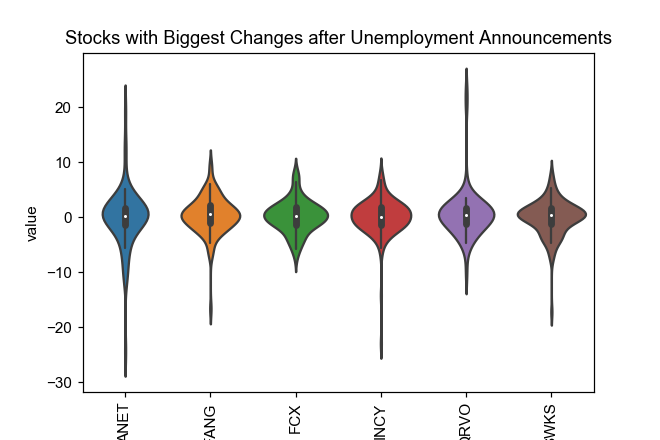

In [171]:
plt.figure(figsize=(6,4))
ax=plt.gca()
plt.title('Stocks with Biggest Changes after Unemployment Announcements')
plt.style.use('seaborn-whitegrid')
plt.xticks(rotation=90)
sns.violinplot('ticker', 'value', data=df_toplot, colormap='viridis', ax=ax);

### Retrieving historical data from [Twitter](https://twitter.com/home?lang=en)

In [172]:
big_movers.drop('means',axis=1)

Release Date,2010-02-05,2010-03-05,2010-04-02,2010-05-07,2010-06-04,2010-07-02,2010-08-06,2010-09-03,2010-10-08,2010-11-05,...,2019-10-04,2019-11-01,2019-12-06,2020-01-10,2020-02-07,2020-03-06,2020-04-03,2020-05-08,2020-06-05,2020-07-02
ANET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.88553,-24.2344,-0.75137,0.319149,-0.322553,-2.94058,0.278207,3.60215,2.84702,0.510886
FANG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.547212,1.20103,4.11559,-2.00743,-2.61052,-16.5779,8.74355,4.23582,9.50084,4.94949
FCX,5.22925,2.37189,1.21697,-2.08605,-5.07783,0.618769,0.72904,2.06601,4.49672,0.914429,...,-0.3386,7.12831,2.7361,-0.462963,-4.22078,-5.60561,-1.09546,2.67559,6.47059,0.0870322
INCY,1.7982,2.29277,2.0979,-4.53048,-3.29835,1.51515,1.60116,2.26415,1.51423,-0.0619963,...,-0.0133547,-0.405148,0.521332,-1.89865,-2.20288,-3.2693,1.97223,-0.570125,-0.309168,3.72138
QRVO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.81477,20.2325,0.775047,1.30404,-4.2088,-3.02158,-4.20037,2.16227,2.00176,1.88435
SWKS,0.672143,1.61082,3.16333,-3.34836,-4.26103,-0.299581,2.34899,2.33062,2.09163,2.06926,...,4.3678,7.9508,1.38028,0.359382,-3.17811,-2.92119,-3.68238,4.73679,5.82109,2.04211


In [173]:
valid_dates=[]
for index in big_movers.index:
    for col in big_movers.drop('means',axis=1):
        if big_movers.notnull().loc[index,col]:
            valid_dates.append((index,col))
len(valid_dates)

611

### Code for retrieving historical twitter data

* The following code was used to retrieve twitter data. A partial amount of the data needed for this project has been retrieved to date and is stored in a csv file in this repository, as API request limits were reached. The additional data needed to complete the project will be retrieved at a later time. Double-click here to better visualize code.

In [174]:
def convert_date_to_string(date,form):
    str_year=str(date.year)
    str_month=str(date.month)
    str_day=str(date.day)
    if date.month<10:
        str_month='0'+str_month
    if date.day<10:
        str_day='0'+str_day
    if form==0:
        return str_year+str_month+str_day+'0000'
    elif form==1:
        return str_year+'-'+str_month+'-'+str_day

def get_tweets(ticker,date):
    premium_search_args = load_credentials(filename="twitter_keysG.yml",
                                       yaml_key="search_tweets_fullarchive_dev",env_overwrite=False)
    rule_str=ticker+" #stocks lang:en"
    date1=convert_date_to_string(date-timedelta(days=1),0)
    date2=convert_date_to_string(date,0)
    rule = gen_rule_payload(pt_rule=rule_str,from_date=date1,to_date=date2)
    rs = ResultStream(rule_payload=rule,**premium_search_args)
    return list(rs.stream())

df_tweets=pd.read_csv('twitterdata.csv').drop(columns=0)
 
for ticker,date in [x for x in reversed(valid_dates) if x[0]=='FCX'][:49]:
    df_tweets.loc[ticker,date]=get_tweets(ticker,date)
df_tweets.to_csv('twitterdata.csv')

In [175]:
def correct_pattern(pattern,text):
    '''This function was created to correct formatting problems created when storing the data'''
    while True:
        try:
            wrong_pattern=re.search(pattern,text).group(0)
            right_pattern=wrong_pattern.replace('"',"'")
            text=text.replace(wrong_pattern,right_pattern)
        except Exception:
            break
    return text

### Example of tweet processing
#### This is a typical list of tweets for ticker FCX on the day before the unemployment rate announcement

In [176]:
df_tweets=pd.read_csv('twitterdata.csv',index_col=1).drop('Unnamed: 0',axis=1)
tweets=list(reversed(df_tweets.loc['FCX',:].dropna()))[3].replace("\'",'"').replace(
    'True','"True"').replace('False','"False"').replace('None','"None"')
re_to_fix=['[A-za-z0-9]"[A-za-z0-9]','href="[^"]+"\srel="[^"]+"']
for pattern in re_to_fix:
    tweets=correct_pattern(pattern,tweets)

tweet_list=[tweet['text'] for tweet in json.loads(tweets)]
tweet_list

['Largest CALL OI increases $ET $MAS $X $BKR $FCX $BABA $TEVA $BAC $CCL $GILD $TWTR $AAL $PDD $F $TME $PG $QCOM… https://t.co/HqSUOHGOKM',
 '1 hour charts for the Group 3 instruments are available for members viewing.. https://t.co/x2kmaKA6Ui #ElliottWave… https://t.co/HcxTrGMiKd',
 '4 hour charts for the Group 3 instruments are available for members view https://t.co/x2kmaKA6Ui #ElliottWave… https://t.co/TS8wOVeh7P',
 '1 hour charts for the Group 3 instruments are available for members viewing.. https://t.co/x2kmaKA6Ui #ElliottWave… https://t.co/kZriWTw8nc',
 'The Group 3 Live Analysis / #Trading Room video recording is available for members https://t.co/x2kmaKA6Ui… https://t.co/Xq5oPwcOHh',
 'We always try to learn from our mistakes! \n$FCX\nSignal: ** SELL **\nSince: 2020-03-27 \nOur performance: % -1.77… https://t.co/lxkXpKhnAZ',
 'The first informative #App on Pivot Points.\nStock: $FCX\nLast close:  (2020-04-01) ($ 6.31)\nPIVOT POINT\n------------… https://t.co/tHdW4cYOG2',
 '$fc

#### Using NLTK and sentiment word lists by Minqing Hu and Bing Liu from the University of Illinois, we will determine the overall sentiment of these tweets

In [177]:
def read_word_file(word_type):
    l=[]
    filename=word_type+'_words.txt'
    with open(filename,'r') as wf:
        for line in wf:
            if line[0] != ';' and line[0] != '\n':
                l.append(line.strip())
    return l
                         
def sentiment_score(txt):
    text=''
    for word in txt.split():
        try:
            if not word.startswith('http'):
                word=re.search('[A-Za-z]+',word).group(0)
                text=text+' '+word
        except Exception:
            a=1
    word_list=list(set(nltk.word_tokenize(text)))
    positive_count=len([x for x in word_list if x in read_word_file('positive')])
    negative_count=len([x for x in word_list if x in read_word_file('negative')])
    return positive_count-negative_count

alltweet_text=''
for item in tweet_list:
    alltweet_text+=str(item)
sentiment_score(alltweet_text)

0

### Documenting sentiment for each ticker for each release date

In [178]:
df_sentiment=pd.DataFrame(index=big_movers.index,columns=df_UR_Releases['Release Date'])
df_sentiment

Release Date,2010-02-05,2010-03-05,2010-04-02,2010-05-07,2010-06-04,2010-07-02,2010-08-06,2010-09-03,2010-10-08,2010-11-05,...,2019-10-04,2019-11-01,2019-12-06,2020-01-10,2020-02-07,2020-03-06,2020-04-03,2020-05-08,2020-06-05,2020-07-02
ANET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FANG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QRVO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SWKS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
for ticker,date in valid_dates:
    try:
        cell=df_tweets.loc[ticker,convert_date_to_string(date,1)]
        if type(cell)==str:
            tweets=df_tweets.loc[ticker,convert_date_to_string(date,1)].replace(
                "\'",'"').replace('True','"True"').replace('False','"False"').replace('None','"None"')
            for pattern in re_to_fix:
                tweets=correct_pattern(pattern,tweets)
            alltweet_text=''
            for tweet in json.loads(tweets):
                alltweet_text+=str(tweet['text'])
            df_sentiment.loc[ticker,date]=sentiment_score(alltweet_text)
    except Exception:
        a=1

<IPython.core.display.Javascript object>


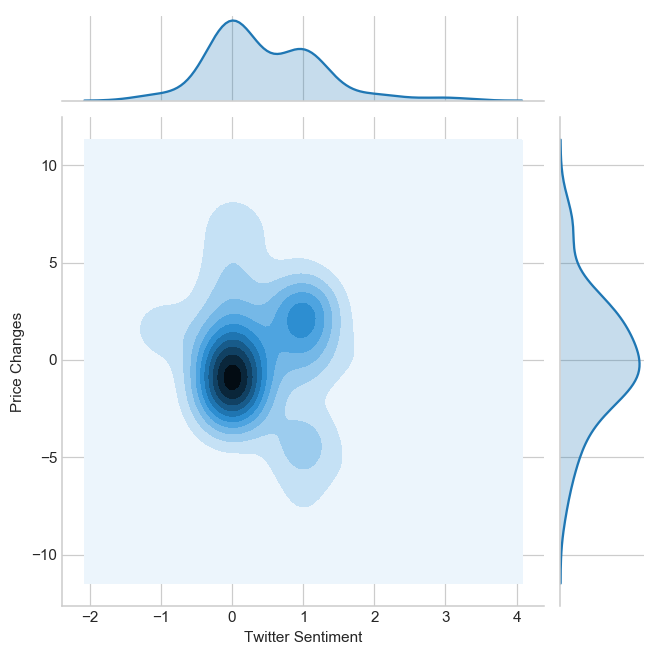

In [182]:
data=pd.DataFrame({'Twitter Sentiment':df_sentiment.loc['FCX','2016-07-08':],
    'Price Changes':df_changes.loc['FCX',datetime(2016,7,8):].drop('means')})
plot=sns.jointplot(x='Twitter Sentiment',y='Price Changes',data=data,kind='kde');
#plot.ax_joint.set_aspect('equal')

In [181]:
pearsonr(data['Twitter Sentiment'],data['Price Changes'])

(-0.15518805795979712, 0.28699367475995824)

<IPython.core.display.Javascript object>


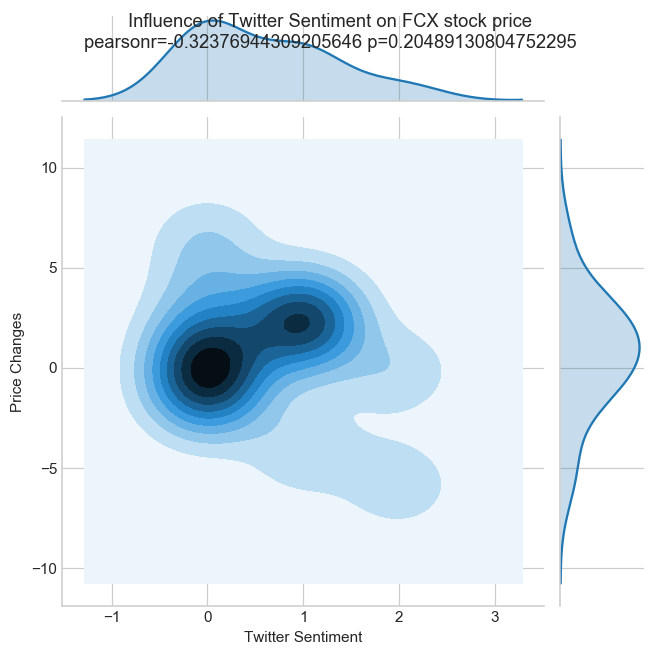

Text(0.5, 0.98, 'Influence of Twitter Sentiment on FCX stock price\npearsonr=-0.32376944309205646 p=0.20489130804752295')

In [197]:
data['ConsistencyWURA']=df_cons.loc['FCX',datetime(2016,7,8):]
data['Selected']=data['ConsistencyWURA']*data['Price Changes']
data1=data[data['Selected']!=0]
stat=pearsonr(data1['Twitter Sentiment'],data1['Price Changes'])
title="Influence of Twitter Sentiment on FCX stock price\npearsonr={} p={}".format(stat[0],stat[1])
sns.jointplot(x='Twitter Sentiment',y='Price Changes',data=data1,kind='kde').fig.suptitle(title)


In [194]:
data1

,Twitter Sentiment,Price Changes,ConsistencyWURA,Selected
Release Date,,,,
2016-10-07,0,-1.65049,1.0,-1.65049
2016-11-04,1,2.98229,1.0,2.98229
2016-12-02,1,2.59481,1.0,2.59481
2017-02-03,2,-5.82986,1.0,-5.82986
2017-05-05,0,1.0274,1.0,1.0274
2017-08-04,0,0.278358,1.0,0.278358
2018-05-04,1,1.38067,1.0,1.38067
2018-06-01,0,1.30178,1.0,1.30178
2018-08-03,1,1.81465,1.0,1.81465


### Next Steps:

* Further data analysis to establish correlations between variables and outcomes, for which additional data is needed, so it will be necessary to retrieve additional data from twitter
* Incorporate data from other economic indicators, such as GDP and initial unemployment claims and analyze correlations
* Building a train/test dataset with relevant features to be used for machine learning
* Determine most suitable ML algorithm and use it to predict future price behavior